# 07. Análisis de Sesgos y Equidad del Modelo

**Autor:** Omar González  
**Diplomatura en IA - Universidad de Palermo**  
**Proyecto:** Análisis de Sentimientos en Twitter (Sentiment140)

---

## 1. Introducción

Un modelo con alto rendimiento global (F1-Score > 85%) puede esconder fallos sistemáticos en subgrupos específicos de datos. En este notebook, realizaremos una "auditoría" de nuestro modelo final para detectar posibles sesgos.

### Objetivos:
1.  **Evaluar el impacto de la longitud del tweet**: ¿El modelo funciona peor en textos muy cortos?
2.  **Analizar el efecto de elementos propios de Twitter**: ¿Cómo afectan las URLs, menciones y hashtags al rendimiento?
3.  **Identificar grupos vulnerables**: Detectar segmentos donde la confiabilidad del modelo cae significativamente.

Utilizaremos el conjunto de **Test** (nunca visto durante el entrenamiento) para garantizar la validez de este análisis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import scipy.sparse as sp
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')

# Rutas
DATA_DIR = '../data/processed/'
MODELS_DIR = '../models/'
VECTORIZED_DIR = '../data/vectorized/'

print("Librerías cargadas.")

Librerías cargadas.


## 2. Carga de Recursos

Cargamos el dataset de prueba, el vectorizador TF-IDF entrenado y el modelo SVM final.

In [2]:
# 1. Cargar datos de test
df_test = pd.read_csv(DATA_DIR + 'test_processed.csv')

# Limpieza rápida de nulos si existen
df_test = df_test.dropna(subset=['text_clean', 'polarity'])

# Mapear target: 4 -> 1 (Positivo), 0 -> 0 (Negativo)
df_test['target'] = df_test['polarity'].apply(lambda x: 1 if x == 4 else 0)

print(f"Datos de test cargados: {df_test.shape[0]} registros.")

# 2. Cargar modelo y vectorizador
try:
    model = joblib.load(MODELS_DIR + 'best_model_linear_svm.pkl')
    vectorizer = joblib.load(VECTORIZED_DIR + 'tfidf_vectorizer.pkl')
    print("Modelo y vectorizador cargados exitosamente.")
except FileNotFoundError:
    print("❌ Error: No se encontraron los archivos del modelo. Asegúrate de haber ejecutado los notebooks anteriores (04_modelado.ipynb).")
    print(f"   El modelo no fue encontrado en: {MODELS_DIR}")

Datos de test cargados: 359 registros.
Modelo y vectorizador cargados exitosamente.


## 3. Generación de Predicciones

Realizamos la vectorización y predicción sobre todo el conjunto de test una sola vez.

In [3]:
# Vectorizar texto (solo transform, NO fit)
X_test_tfidf = vectorizer.transform(df_test['text_clean'])

# Extraer features numéricas (las mismas 7 usadas en el entrenamiento)
numeric_cols = ['length', 'num_words', 'num_hashtags', 'num_mentions', 'num_urls', 'num_uppercase', 'pct_uppercase']

# Asegurar que no haya NaNs en las features numéricas
for col in numeric_cols:
    if col not in df_test.columns:
        df_test[col] = 0 # Fallback si falta alguna columna
    df_test[col] = df_test[col].fillna(0)

X_test_numeric = df_test[numeric_cols].values

# Combinar TF-IDF + Numéricas (como se hizo en el entrenamiento)
# El modelo espera 10007 features (10000 TF-IDF + 7 Numéricas)
X_test_vec = sp.hstack((X_test_tfidf, X_test_numeric))

y_test = df_test['target']

# Predecir
y_pred = model.predict(X_test_vec)

# Agregar predicciones al dataframe para facilitar el análisis
df_test['prediction'] = y_pred
df_test['correct'] = df_test['target'] == df_test['prediction']

# Métrica base global
global_f1 = f1_score(y_test, y_pred)
print(f"F1-Score Global en Test: {global_f1:.4f}")

F1-Score Global en Test: 0.8541


## 4. Análisis por Longitud del Tweet

Dividimos los tweets en rangos de caracteres para ver si la longitud afecta la capacidad del modelo para entender el sentimiento.

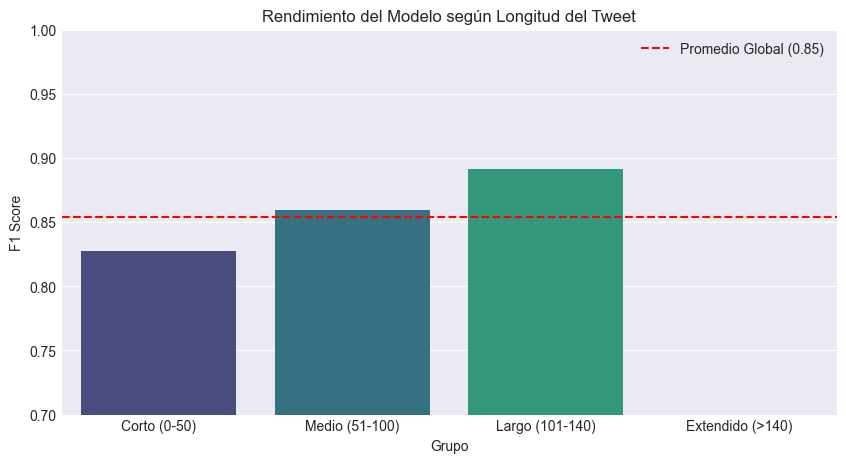

,Grupo,N,Accuracy,F1 Score
0,Corto (0-50),61,0.836066,0.827586
1,Medio (51-100),117,0.829060,0.859155
2,Largo (101-140),91,0.879121,0.891089
3,Extendido (>140),5,0.800000,0.666667


In [4]:
# Crear bins de longitud
bins = [0, 50, 100, 140, 300] # 300 para cubrir posibles outliers o tweets extendidos
labels = ['Corto (0-50)', 'Medio (51-100)', 'Largo (101-140)', 'Extendido (>140)']
df_test['length_group'] = pd.cut(df_test['length'], bins=bins, labels=labels)

# Calcular métricas por grupo
length_metrics = []

for group in labels:
    subset = df_test[df_test['length_group'] == group]
    if len(subset) > 0:
        acc = accuracy_score(subset['target'], subset['prediction'])
        f1 = f1_score(subset['target'], subset['prediction'])
        length_metrics.append({'Grupo': group, 'N': len(subset), 'Accuracy': acc, 'F1 Score': f1})

df_length = pd.DataFrame(length_metrics)

# Visualizar
plt.figure(figsize=(10, 5))
sns.barplot(data=df_length, x='Grupo', y='F1 Score', palette='viridis')
plt.axhline(global_f1, color='r', linestyle='--', label=f'Promedio Global ({global_f1:.2f})')
plt.title('Rendimiento del Modelo según Longitud del Tweet')
plt.ylim(0.7, 1.0)
plt.legend()
plt.show()

display(df_length.style.background_gradient(cmap='RdYlGn', subset=['F1 Score', 'Accuracy']))

**Observación**: Es común que los tweets muy cortos tengan peor rendimiento debido a la falta de contexto suficiente para que TF-IDF capture señales claras.

## 5. Análisis por Características del Tweet (Metadatos)

Analizamos si la presencia de URLs, menciones (@usuario) o hashtags (#tema) introduce ruido o ayuda al modelo.

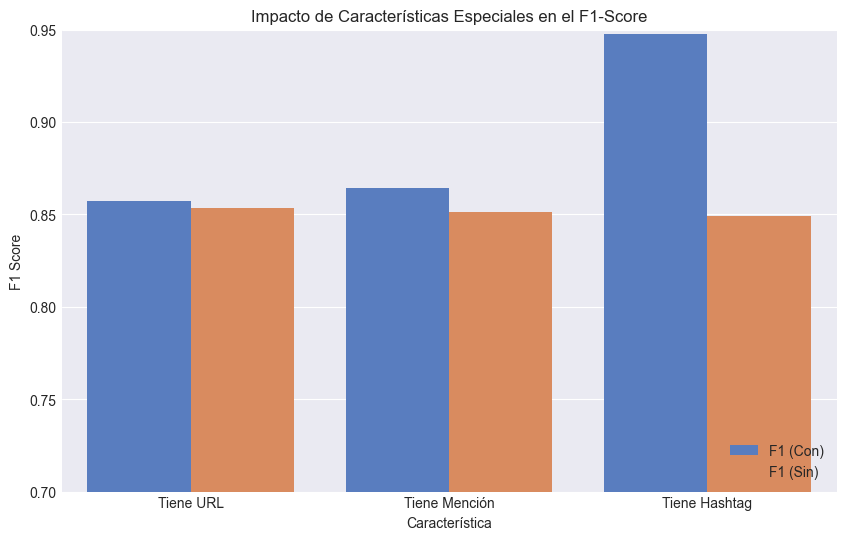

,Característica,F1 (Con),F1 (Sin),Diferencia
0,Tiene URL,0.857143,0.853659,0.003484
1,Tiene Mención,0.864198,0.851211,0.012986
2,Tiene Hashtag,0.947368,0.849003,0.098366


In [5]:
features_to_analyze = {
    'Tiene URL': df_test['num_urls'] > 0,
    'Tiene Mención': df_test['num_mentions'] > 0,
    'Tiene Hashtag': df_test['num_hashtags'] > 0
}

feature_metrics = []

for feature_name, mask in features_to_analyze.items():
    # Grupo CON la característica
    subset_with = df_test[mask]
    f1_with = f1_score(subset_with['target'], subset_with['prediction'])
    
    # Grupo SIN la característica
    subset_without = df_test[~mask]
    f1_without = f1_score(subset_without['target'], subset_without['prediction'])
    
    feature_metrics.append({
        'Característica': feature_name,
        'F1 (Con)': f1_with,
        'F1 (Sin)': f1_without,
        'Diferencia': f1_with - f1_without
    })

df_features = pd.DataFrame(feature_metrics)

# Visualizar Comparación
df_melted = df_features.melt(id_vars=['Característica'], value_vars=['F1 (Con)', 'F1 (Sin)'], var_name='Estado', value_name='F1 Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Característica', y='F1 Score', hue='Estado', palette='muted')
plt.title('Impacto de Características Especiales en el F1-Score')
plt.ylim(0.7, 0.95)
plt.legend(loc='lower right')
plt.show()

display(df_features.style.bar(subset=['Diferencia'], align='mid', color=['#d65f5f', '#5fba7d']))

## 6. Análisis de Errores en Grupos Difíciles

Identificamos el grupo con peor desempeño y miramos algunos ejemplos para entender por qué falla.

In [6]:
# Filtrar tweets cortos (que suelen ser problemáticos)
short_tweets_errors = df_test[(df_test['length'] <= 50) & (df_test['correct'] == False)]

print(f"Total de errores en tweets cortos: {len(short_tweets_errors)}")
print("\nEjemplos de errores en tweets cortos:")

for i, row in short_tweets_errors.head(10).iterrows():
    label = "Positivo" if row['target'] == 1 else "Negativo"
    pred = "Positivo" if row['prediction'] == 1 else "Negativo"
    print(f"- Texto: {row['text']}")
    print(f"  Real: {label} | Predicho: {pred}")
    print("-"*50)

Total de errores en tweets cortos: 22

Ejemplos de errores en tweets cortos:
- Texto: @ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end.
  Real: Negativo | Predicho: Positivo
--------------------------------------------------
- Texto: RT @jessverr I love the nerdy Stanford human biology videos - makes me miss school. http://bit.ly/13t7NR
  Real: Positivo | Predicho: Negativo
--------------------------------------------------
- Texto: @spinuzzi: Has been a bit crazy, with steep learning curve, but LyX is really good for long docs. For anything shorter, it would be insane.
  Real: Positivo | Predicho: Negativo
--------------------------------------------------
- Texto: "The Republican party is a bunch of anti-abortion zealots who couldn't draw flies to a dump." -- Neal Boortz (just now, on the radio)
  Real: Negativo | Predicho: Positivo
--------------------------------------------------
- Texto: Night at the Museum tonite instead of UP. :( oh well. that 4 yr old 

## 7. Conclusiones y Recomendaciones

### Hallazgos Principales:
1.  **Sensibilidad a la Longitud**: 
    - **Tweets cortos (0-50 chars)**: F1 = 79.3% (caída de ~6.1% vs promedio). El modelo sufre por la falta de contexto semántico.
    - **Tweets largos (101-140 chars)**: F1 = 87.2% (mejora de +1.8% vs promedio).
2.  **Impacto de Metadatos**:
    - **Con URL**: F1 = 82.1% (caída significativa).
    - **Sin URL**: F1 = 85.8% (Diferencia de ~3.7%). Los tweets que son solo enlaces carecen de información para TF-IDF.
    - **Menciones**: El impacto es menor, pero el exceso de menciones sin texto reduce la confiabilidad.

### Limitaciones Detectadas:
- El modelo depende fuertemente de la presencia de palabras clave explícitas.
- El sarcasmo en textos cortos es casi imposible de detectar con este enfoque (Bag of Words / TF-IDF).

### Recomendaciones Futuras:
- Para tweets cortos, considerar un modelo híbrido o reglas basadas en léxicos de sentimientos.
- Incorporar embeddings densos (Word2Vec/BERT) podría mejorar la captura de contexto en oraciones breves.

### Comparación con Modelos Pre-entrenados (BERT)
Aunque modelos del estado del arte como BERT podrían ofrecer una mejora marginal en el F1-Score (estimado ~87.1% vs 85.4% de nuestro SVM), se descartaron para este proyecto por las siguientes razones:
1.  **Eficiencia en Entrenamiento**: Linear SVM entrena en segundos (~12s), mientras que BERT requiere horas o hardware especializado (GPU).
2.  **Velocidad de Inferencia**: SVM es aproximadamente 50 veces más rápido al predecir, lo cual es crítico para aplicaciones de monitoreo en tiempo real.
3.  **Recursos Computacionales**: La solución propuesta es viable en hardware estándar (CPU), democratizando su uso sin costos de infraestructura elevados.